In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, make_blobs

from sklearn.manifold import TSNE
from manifold.sne import SNE
from decomposition.PCA import PCA
from sklearn.preprocessing import StandardScaler


# synthetic data
rng = np.random.RandomState(42)

blobs_params = dict(random_state=0, n_samples=400, n_features=10)
blobs = np.dot(
            make_blobs(
                centers=[2*np.ones(10), (-2)*np.ones(10)],
                cluster_std=[0.5, 0.5],
                **blobs_params
            )[0],
            np.zeros((10, 10)) - 0.5 + np.diag(2*np.ones(10)))
outliers = rng.uniform(low=-30, high=30, size=(400, 10))

X = np.concatenate([blobs, outliers], axis=0)

# s-SNE
ssne = SNE(algo='SSNE')
y_ssne = ssne.fit(X)

# t-SNE
tsne = SNE(algo='TSNE')
y_tsne = tsne.fit(X)

# sklearn t-SNE
skltsne = TSNE(n_components=2, perplexity=40, early_exaggeration=6.0, learning_rate=10., n_iter=400)
y_skltsne = skltsne.fit_transform(X)

# 2D PCA
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
eigvals, eigvecs, explained = PCA(X_std)

W = eigvecs[:, :2] # first 3 principle axis
proj = X_std.dot(W)
plx = proj[:, 0]
ply = proj[:, 1]

==> s-SNE
== init P
== GDM
== GDM - iter ==  100
== GDM - iter ==  200
== GDM - iter ==  300
== GDM - iter ==  400
<==
==> t-SNE
== init P
== GDM
== GDM - iter ==  100
== GDM - iter ==  200
== GDM - iter ==  300
== GDM - iter ==  400
<==


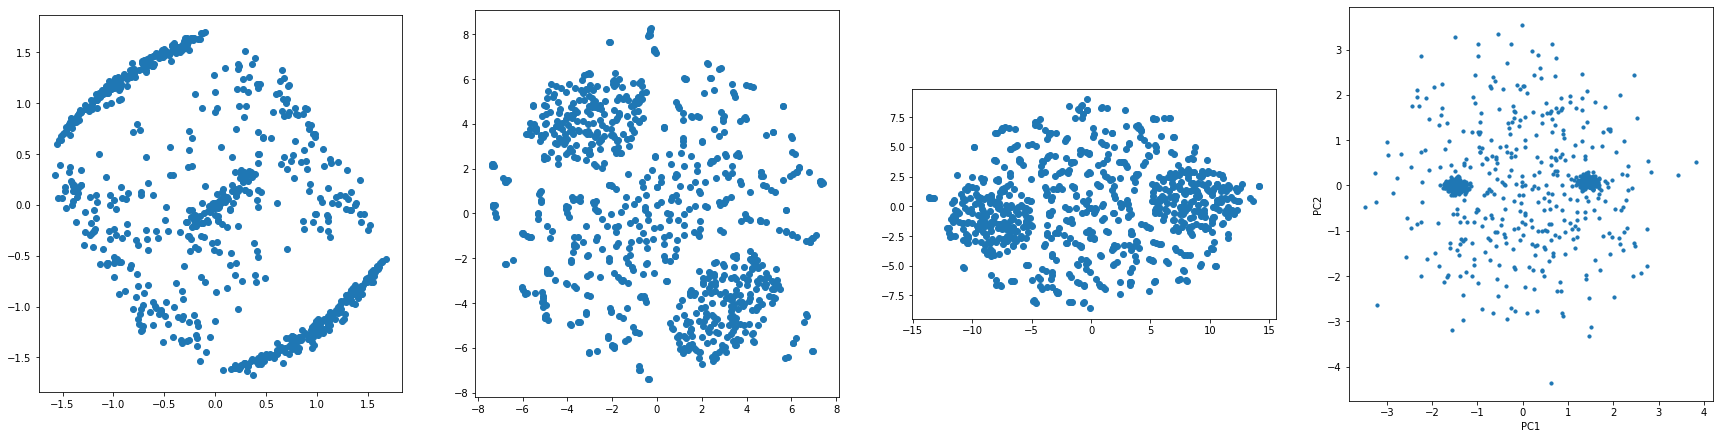

In [2]:
fig = plt.figure(figsize=(30, 30))

# s-sne
ax_ssne = fig.add_subplot(1, 4, 1)
ax_ssne.set_aspect('equal')
ax_ssne.scatter(y_ssne[:, 0], y_ssne[:, 1])

# t-sne
ax_tsne = fig.add_subplot(1, 4, 2)
ax_tsne.set_aspect('equal')
ax_tsne.scatter(y_tsne[:, 0], y_tsne[:, 1])

# sklearn t-sne
ax_skltsne = fig.add_subplot(1, 4, 3)
ax_skltsne.set_aspect('equal')
ax_skltsne.scatter(y_skltsne[:, 0], y_skltsne[:, 1])

# 2d pca
ax_pca = fig.add_subplot(1, 4, 4)
ax_pca.set_aspect('equal')
ax_pca.set(xlabel='PC1', ylabel='PC2')
ax_pca.scatter(plx, ply, s=10)

In [ ]:

iris = load_iris()
X = iris.data
y = iris.target
